# Univariate ARIMA Models

In [76]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)



In [77]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
sns.set_style('whitegrid')

This defines a custom function plot_correlogram to visualize time series residuals for model diagnostics:

- Top-left: Residual plot with a 21-period rolling mean.
- Annotates Q-Statistic (for autocorrelation) and ADF p-value (for stationarity).
- Top-right: Q-Q plot for normality, with stats (mean, SD, skew, kurtosis).
- Bottom: ACF and PACF plots to check for remaining autocorrelation.


In [79]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0], auto_ylims=True)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1], auto_ylims=True)
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

Load monthly industrial production and daily NASDAQ stock market index:

In [80]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

nasdaq = nasdaq.asfreq('B', method='ffill')  # Forward-fill NaNs for holidays/weekends

In [81]:
print(industrial_production.shape)
industrial_production

(360,)


DATE
1988-01-01     55.6315
1988-02-01     56.8324
1988-03-01     57.5487
1988-04-01     57.7727
1988-05-01     57.8687
                ...   
2017-08-01    100.7360
2017-09-01    100.3586
2017-10-01    101.9040
2017-11-01    100.6590
2017-12-01     99.5281
Name: IPGMFN, Length: 360, dtype: float64

In [82]:
print(nasdaq.shape)
nasdaq

(7304,)


DATE
1990-01-02     459.33
1990-01-03     460.90
1990-01-04     459.39
1990-01-05     458.22
1990-01-08     458.71
               ...   
2017-12-25    6959.96
2017-12-26    6936.25
2017-12-27    6939.34
2017-12-28    6950.16
2017-12-29    6903.39
Freq: B, Name: NASDAQCOM, Length: 7304, dtype: float64

### Log Transformation

Computes natural log of both series to handle multiplicative effects and make them more stationary.

In [83]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### Differencing

Header for differencing, which removes trends to achieve stationarity.

In [84]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
# industrial_production_log_diff = industrial_production_log.diff(12).dropna()
# industrial_production_log_diff = industrial_production_log_diff.asfreq('MS')

industrial_production_log = np.log(industrial_production).asfreq('MS')
industrial_production_log_diff = industrial_production_log.diff(12).dropna().asfreq('MS')
print(industrial_production_log_diff.shape)

(348,)


## Univariate Time Series Models

### Autoregressive (AR) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms.
While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:
- Autoregressive (AR) terms consisting of p-lagged values of the time series
- Moving average (MA) terms that contain q-lagged disturbances


Chapter 9 introduces the ARIMA building blocks, simple autoregressive (AR) and moving average (MA) models, and explains how to combine them in autoregressive moving-average (ARMA) models that may account for series integration as ARIMA models or include exogenous variables as AR(I)MAX models. 

Furthermore, we will illustrate how to include seasonal AR and MA terms to extend the toolbox to also include SARMAX models.

### ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [85]:
model1 = tsa.ARIMA(endog=nasdaq_log_diff, order=(2,0,2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()


In [86]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              NASDAQCOM   No. Observations:                 7303
Model:                 ARIMA(2, 0, 2)   Log Likelihood               20659.995
Date:                Mon, 15 Sep 2025   AIC                         -41307.989
Time:                        00:15:55   BIC                         -41266.613
Sample:                    01-03-1990   HQIC                        -41293.762
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.173      0.030    3.63e-05       0.001
ar.L1          0.2034      0.403      0.504      0.614      -0.587       0.994
ar.L2          0.1877      0.330      0.570      0.569      -0.458       0.834
ma.L1         -0.2184      0.402     -0.544      0.586      -1.005       0.569
ma.L2         -0.2114      0.334     -0.633      0.527      -0.866       0.443
sigma2         0.0002   1.67e-06    122.558      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13025.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              NASDAQCOM   No. Observations:                 7304
Model:                 ARIMA(2, 1, 2)   Log Likelihood               20657.175
Date:                Mon, 15 Sep 2025   AIC                         -41304.350
Time:                        00:15:55   BIC                         -41269.870
Sample:                    01-02-1990   HQIC                        -41292.494
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2115      0.410      0.516      0.606      -0.591       1.014
ar.L2          0.1444      0.334      0.432      0.666      -0.511       0.800
ma.L1         -0.2257      0.408     -0.553      0.580      -1.025       0.574
ma.L2         -0.1674      0.338     -0.495      0.621      -0.831       0.496
sigma2         0.0002   1.66e-06    122.966      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             13045.80
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
# Align the indices and compare only the common parameters
common_idx = model1.params.index.intersection(model2.params.index)
model1.params.loc[common_idx].sort_index() == model2.params.loc[common_idx].sort_index()

ar.L1     False
ar.L2     False
ma.L1     False
ma.L2     False
sigma2    False
dtype: bool

### Seasonal differencing vs SARIMAX

Seasonal differencing has same effect as using SARIMAX w seasonal order `(0,1,0,12)`.

In [89]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()


In [90]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.769467,1.769467
ar.L2,-0.791823,-0.791823
ma.L1,-0.845315,-0.845315
ma.L2,0.313131,0.313131
sigma2,0.000102,0.000102


## Finding the optimal ARMA lags

### Run candidate models

We iterate over various (p, q) lag combinations and collect diagnostic statistics to compare the result.

<span style="color:red">This takes a while...5+ minutes</span>

In [91]:
# train_size = 120
# results = {}
# y_true = industrial_production_log_diff.iloc[train_size:]

# for p in range(5):
#     for q in range(5):
#         aic, bic = [], []
#         if p == 0 and q == 0:
#             continue
#         print(p, q)
#         convergence_error = stationarity_error = 0
#         y_pred = []
#         for T in range(train_size, len(industrial_production_log_diff)):
#             train_set = industrial_production_log_diff.iloc[T-train_size:T]
#             try:
#                 # model = tsa.ARIMA(endog=train_set, order=(p, 0, q)).fit()
#                 model = tsa.statespace.SARIMAX(endog=train_set, order=(p, 0, q), seasonal_order=(0, 0, 0, 0)).fit(maxiter=200, disp=False)
#             except LinAlgError:
#                 convergence_error += 1
#             except ValueError:
#                 stationarity_error += 1

#             forecast = model.forecast(steps=1)
#             y_pred.append(forecast[0])
#             aic.append(model.aic)
#             bic.append(model.bic)

#         result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
#                   .replace(np.inf, np.nan)
#                   .dropna())

#         rmse = np.sqrt(mean_squared_error(
#             y_true=result.y_true, y_pred=result.y_pred))

#         results[(p, q)] = [rmse,
#                            np.mean(aic),
#                            np.mean(bic),
#                            convergence_error,
#                            stationarity_error]

In [92]:
# arma_results = pd.DataFrame(results).T
# arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
# arma_results.index.names = ['p', 'q']
# arma_results.info()

In [93]:
# Load saved results instead of computing
with pd.HDFStore('arima.h5') as store:
    arma_results = store.get('arma')


arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (np.int64(0), np.int64(1)) to (np.int64(4), np.int64(4))
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.5 KB


In [94]:
arma_results

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
0 1  0.029242 -487.964882 -482.389899          0.0           0.0
  2  0.022857 -559.570197 -551.207721          0.0           0.0
  3  0.018165 -623.362113 -612.212146          0.0           0.0
  4  0.014284 -662.192958 -648.255499          0.0           0.0
1 0  0.011531 -726.904528 -721.329544          0.0           0.0
  1  0.011528 -729.882707 -721.520231          0.0           0.0
  2  0.010946 -742.713566 -731.563599          0.0           0.0
  3  0.010789 -745.937335 -731.999876          0.0           0.0
  4  0.010584 -751.717624 -734.992674          0.0           0.0
2 0  0.011509 -733.821168 -725.458693          0.0           0.0
  1  0.011709 -728.856501 -717.706534          0.0           0.0
  2  0.009983 -756.616437 -742.678978          0.0           0.0
  3  0.010049 -758.245874 -741.520924          0.0           0.0
  4  0.009976 -756.769708 -737.257265          0.0           0.0
3 0  0.010539 -746.785833 -735.635866          0.0           0.0
  1  0.010188 -752.229379 -738.291920          0.0           0.0
  2  0.010148 -755.797294 -739.072343          0.0           0.0
  3  0.010008 -756.919019 -737.406577          0.0           0.0
  4  0.010153 -756.179338 -733.879404          0.0           0.0
4 0  0.010050 -756.500601 -742.563143          0.0           0.0
  1  0.010020 -756.636805 -739.911855          0.0           0.0
  2  0.010209 -754.724345 -735.211903          0.0           0.0
  3  0.010954 -755.561322 -733.261388          1.0           0.0
  4  0.010254 -757.831246 -732.743821          0.0           0.0

In [95]:
# with pd.HDFStore('arima.h5') as store:
#     store.put('arma', arma_results)

We aim to minimize both RMSE and BIC:

In [96]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
2 4  0.009976 -756.769708 -737.257265          0.0           0.0
  2  0.009983 -756.616437 -742.678978          0.0           0.0
3 3  0.010008 -756.919019 -737.406577          0.0           0.0
4 1  0.010020 -756.636805 -739.911855          0.0           0.0
2 3  0.010049 -758.245874 -741.520924          0.0           0.0

In [97]:
arma_results.nsmallest(5, columns=['BIC'])

,,RMSE,AIC,BIC,convergence,stationarity
p,q,,,,,
2,2,0.009983,-756.616437,-742.678978,0.0,0.0
4,0,0.010050,-756.500601,-742.563143,0.0,0.0
2,3,0.010049,-758.245874,-741.520924,0.0,0.0
4,1,0.010020,-756.636805,-739.911855,0.0,0.0
3,2,0.010148,-755.797294,-739.072343,0.0,0.0


### Plots heatmaps:

- Left: RMSE (filtered <0.5, scaled x10) for (p,q) grid.
- Right: BIC.

Visualizes best parameters (darker = better)

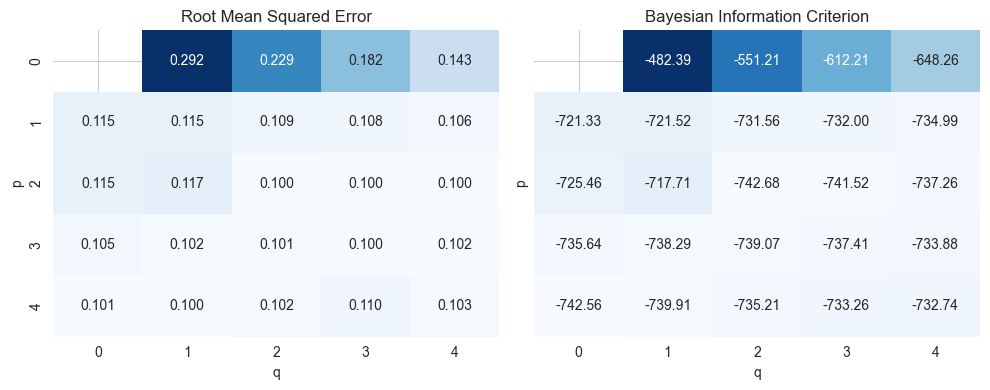

In [98]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

### Rank Average

Ranks models by RMSE and BIC, averages ranks, shows top 5 (balances both criteria).

In [99]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
2  2    1.5
   3    4.0
4  0    4.0
   1    4.0
2  4    4.5
dtype: float64

### Estimating the best ARMA Model

ARMA(4,0) and ARMA(4,1) are close, so we chose the more parsimonious (4,0) configuration:

In [100]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()
print(f"best_p {best_p} , best_q: {best_q}")

best_p 2 , best_q: 2


In [101]:
best_arma_model = tsa.ARIMA(endog=industrial_production_log_diff, order=(best_p, 0, best_q)).fit()
print(best_arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 IPGMFN   No. Observations:                  348
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1105.774
Date:                Mon, 15 Sep 2025   AIC                          -2199.549
Time:                        00:15:55   BIC                          -2176.435
Sample:                    01-01-1989   HQIC                         -2190.347
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.009      2.258      0.024       0.003       0.038
ar.L1          1.8130      0.042     43.508      0.000       1.731       1.895
ar.L2         -0.8396      0.040    -20.946      0.0

### Check Residual Correlogram

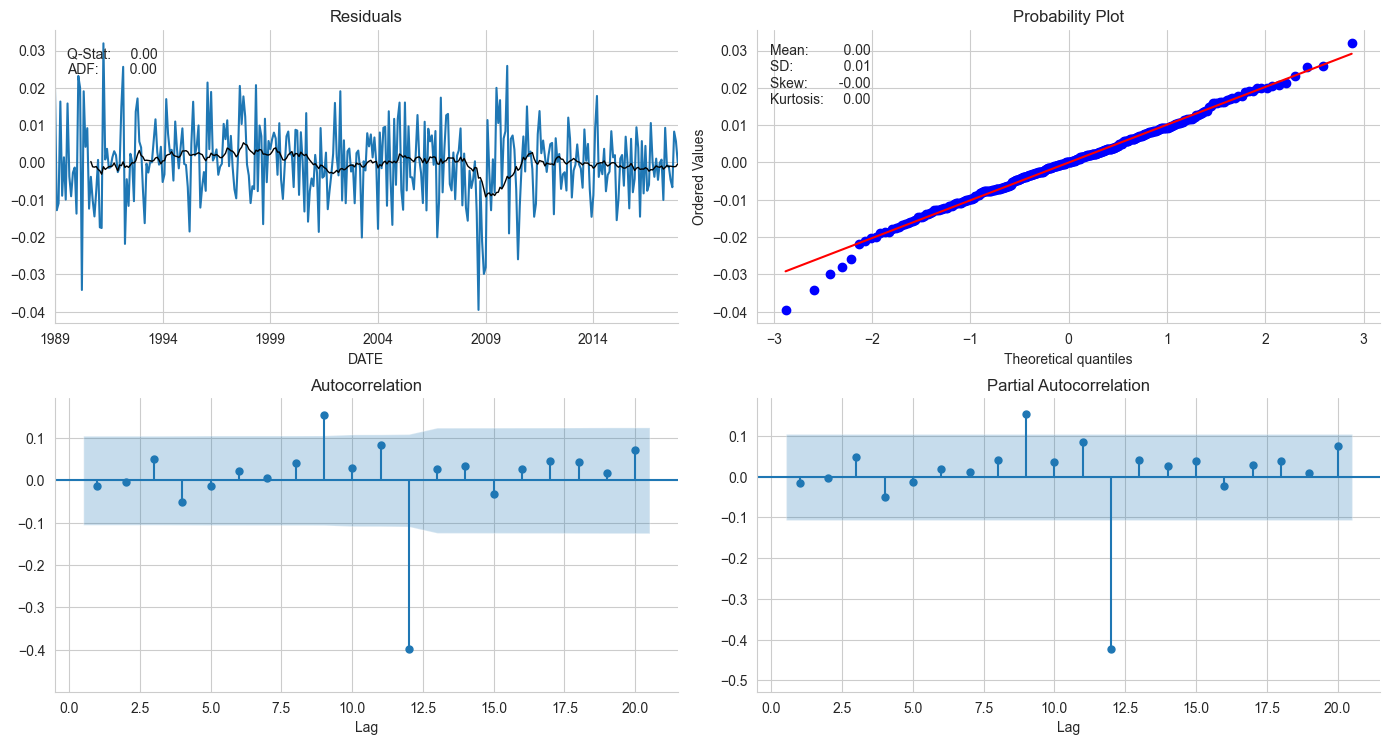

In [102]:
plot_correlogram(best_arma_model.resid,lags=20)

## SARIMAX

Fits `SARIMAX(2,0,2)x(1,0,1,12)` on differenced series (seasonal AR/MA terms).

In [103]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [104]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                1126.804
Date:                              Mon, 15 Sep 2025   AIC                          -2239.607
Time:                                      00:15:56   BIC                          -2212.642
Sample:                                           0   HQIC                         -2228.872
                                              - 348                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0132      0.514      0.026      0.980      -0.994       1.020
ar.L2          0.98

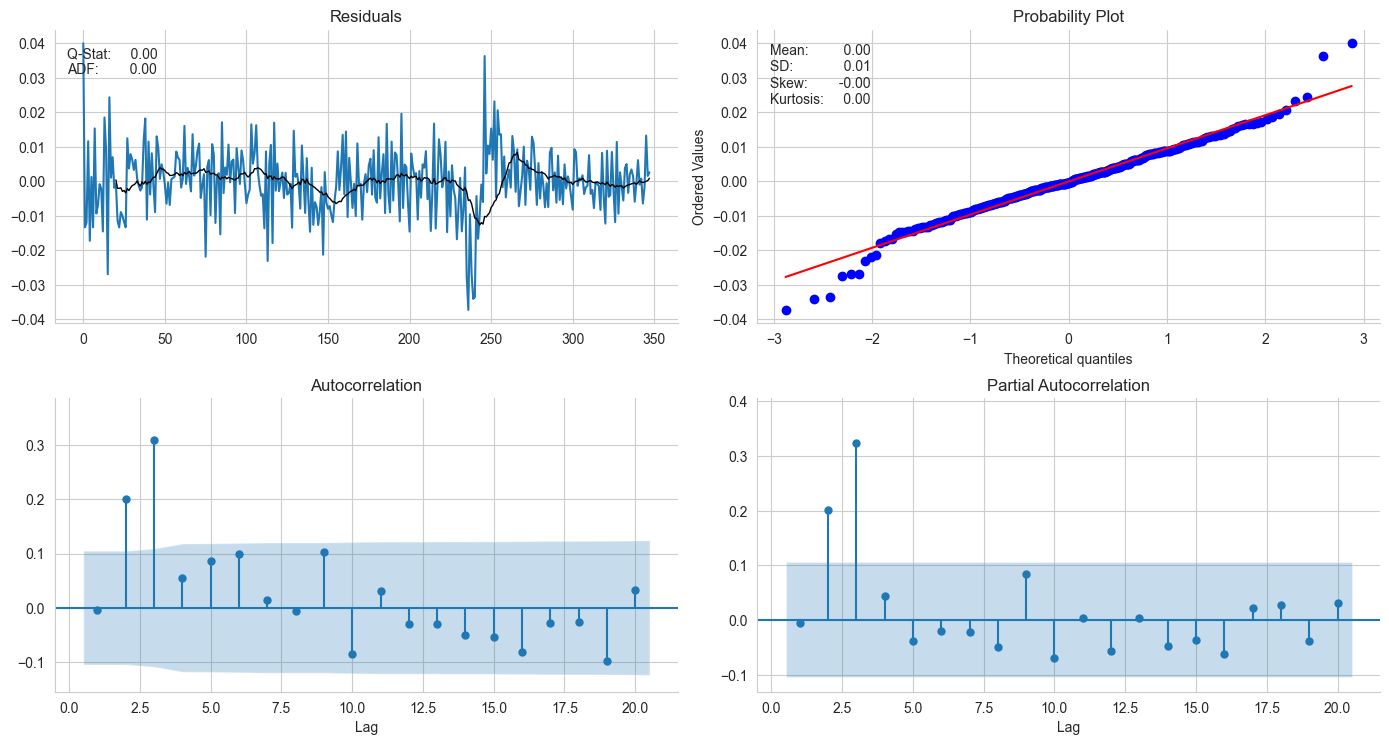

In [105]:
plot_correlogram(pd.Series(sarimax_model.resid),lags=20)

We will build a SARIMAX model for monthly data on an industrial production time series for the 1988-2017 period. As illustrated in the first section on analytical tools, the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecast.

### Finding the optimal number of lags

<span style="color:red">This takes a while...90+ minutes</span>

Generates parameter grid: p1=1-3, q1=1-3, p2=0-2, q2=0-2 (72 combinations, skips p1=0 or q1=0).

In [106]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

81

In [107]:
params

[(1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 0, 2),
 (1, 1, 1, 0),
 (1, 1, 1, 1),
 (1, 1, 1, 2),
 (1, 1, 2, 0),
 (1, 1, 2, 1),
 (1, 1, 2, 2),
 (1, 2, 0, 0),
 (1, 2, 0, 1),
 (1, 2, 0, 2),
 (1, 2, 1, 0),
 (1, 2, 1, 1),
 (1, 2, 1, 2),
 (1, 2, 2, 0),
 (1, 2, 2, 1),
 (1, 2, 2, 2),
 (1, 3, 0, 0),
 (1, 3, 0, 1),
 (1, 3, 0, 2),
 (1, 3, 1, 0),
 (1, 3, 1, 1),
 (1, 3, 1, 2),
 (1, 3, 2, 0),
 (1, 3, 2, 1),
 (1, 3, 2, 2),
 (2, 1, 0, 0),
 (2, 1, 0, 1),
 (2, 1, 0, 2),
 (2, 1, 1, 0),
 (2, 1, 1, 1),
 (2, 1, 1, 2),
 (2, 1, 2, 0),
 (2, 1, 2, 1),
 (2, 1, 2, 2),
 (2, 2, 0, 0),
 (2, 2, 0, 1),
 (2, 2, 0, 2),
 (2, 2, 1, 0),
 (2, 2, 1, 1),
 (2, 2, 1, 2),
 (2, 2, 2, 0),
 (2, 2, 2, 1),
 (2, 2, 2, 2),
 (2, 3, 0, 0),
 (2, 3, 0, 1),
 (2, 3, 0, 2),
 (2, 3, 1, 0),
 (2, 3, 1, 1),
 (2, 3, 1, 2),
 (2, 3, 2, 0),
 (2, 3, 2, 1),
 (2, 3, 2, 2),
 (3, 1, 0, 0),
 (3, 1, 0, 1),
 (3, 1, 0, 2),
 (3, 1, 1, 0),
 (3, 1, 1, 1),
 (3, 1, 1, 2),
 (3, 1, 2, 0),
 (3, 1, 2, 1),
 (3, 1, 2, 2),
 (3, 2, 0, 0),
 (3, 2, 0, 1),
 (3, 2, 0, 2),
 (3, 2, 1,

Similar to ARMA grid but for SARIMAX:

- Rolling 120-month train, 1-step forecast.
- Collects RMSE, RMSE std, AIC/BIC means/stds, errors.

Uses tqdm for progress.

In [108]:
# train_size = 120 # 10 years of training data
# results = {}
# test_set = industrial_production_log_diff.iloc[train_size:]

# for p1, q1, p2, q2 in tqdm(params):
#     preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
#     aic, bic = [], []
#     if p1 == 0 and q1 == 0:
#         continue
#     convergence_error = stationarity_error = 0
#     y_pred = []
#     for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
#         train_set = industrial_production_log_diff.iloc[T-train_size:T]
#         try:
#             with warnings.catch_warnings():
#                 warnings.filterwarnings("ignore")
#                 model = tsa.SARIMAX(endog=train_set.values,
#                                 order=(p1, 0, q1),
#                                 seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
#         except LinAlgError:
#             convergence_error += 1
#         except ValueError:
#             stationarity_error += 1

#         preds.iloc[i, 1] = model.forecast(steps=1)[0]
#         aic.append(model.aic)
#         bic.append(model.bic)

#     preds.dropna(inplace=True)
#     mse = mean_squared_error(preds.y_true, preds.y_pred)
#     results[(p1, q1, p2, q2)] = [np.sqrt(mse),
#                                       preds.y_true.sub(preds.y_pred).pow(2).std(),
#                                       np.mean(aic),
#                                       np.std(aic),                                                  
#                                       np.mean(bic),
#                                       np.std(bic),                                                  
#                                       convergence_error,
#                                       stationarity_error]

### Compare model metrics

In [109]:
# sarimax_results = pd.DataFrame(results).T
# sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
# sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
# sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
# sarimax_results.info()

In [110]:
# Load saved results instead of computing
with pd.HDFStore('arima.h5') as store:
    sarimax_results = store.get('sarimax')

sarimax_results

sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 81 entries, (np.int64(1), np.int64(1), np.int64(0), np.int64(0)) to (np.int64(3), np.int64(3), np.int64(2), np.int64(2))
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          81 non-null     float64
 1   RMSE_std      81 non-null     float64
 2   AIC           81 non-null     float64
 3   AIC_std       81 non-null     float64
 4   BIC           81 non-null     float64
 5   BIC_std       81 non-null     float64
 6   convergence   81 non-null     float64
 7   stationarity  81 non-null     float64
 8   CV            81 non-null     float64
dtypes: float64(9)
memory usage: 6.7 KB


In [111]:
sarimax_results.nsmallest(5, columns='RMSE')

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  3  0  2   0.008957  0.000176 -775.398468  25.851644 -753.098534  25.851644   
3  2  1  1   0.008958  0.000161 -773.265799  21.206257 -750.965865  21.206257   
   3  1  2   0.008997  0.000164 -773.953720  27.241993 -746.078803  27.241993   
         1   0.009008  0.000153 -771.799826  25.349487 -746.712400  25.349487   
      0  2   0.009033  0.000163 -772.421676  28.578673 -747.334251  28.578673   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  3  0  2           0.0           0.0  0.019695  
3  2  1  1           0.0           0.0  0.017936  
   3  1  2           0.0           0.0  0.018207  
         1           0.0           0.0  0.016978  
      0  2           0.0           0.0  0.017994

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

Shows top 5 by RMSE, with AIC/BIC.

In [112]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

RMSE         AIC         BIC
p1 q1 p2 q2                                  
2  3  0  2   0.008957 -775.398468 -753.098534
3  2  1  1   0.008958 -773.265799 -750.965865
   3  1  2   0.008997 -773.953720 -746.078803
         1   0.009008 -771.799826 -746.712400
      0  2   0.009033 -772.421676 -747.334251

In [113]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

,RMSE,AIC,BIC
RMSE,1.000000,0.915515,0.754607
AIC,0.915515,1.000000,0.869264
BIC,0.754607,0.869264,1.000000


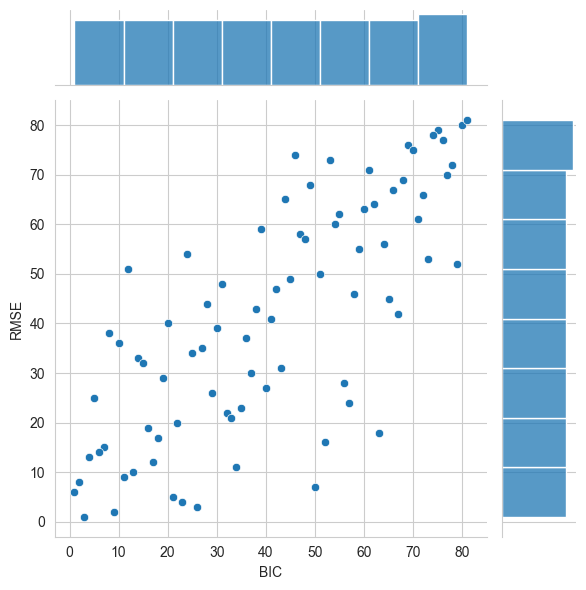

In [121]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [115]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

,,,,RMSE,RMSE_std,AIC,AIC_std,BIC,BIC_std,convergence,stationarity,CV
p1,q1,p2,q2,,,,,,,,,
2,3,0,2,0.008957,0.000176,-775.398468,25.851644,-753.098534,25.851644,0.0,0.0,0.019695


### Train best model

In [125]:
p1, q1, p2, q2 = 2, 3, 1, 2

In [126]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [127]:
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  348
Model:             SARIMAX(2, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                1155.532
Date:                                 Mon, 15 Sep 2025   AIC                          -2293.064
Time:                                         00:27:21   BIC                          -2258.394
Sample:                                              0   HQIC                         -2279.261
                                                 - 348                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3561      0.129     10.505      0.000       1.103       1

### Check Residual Correlogram

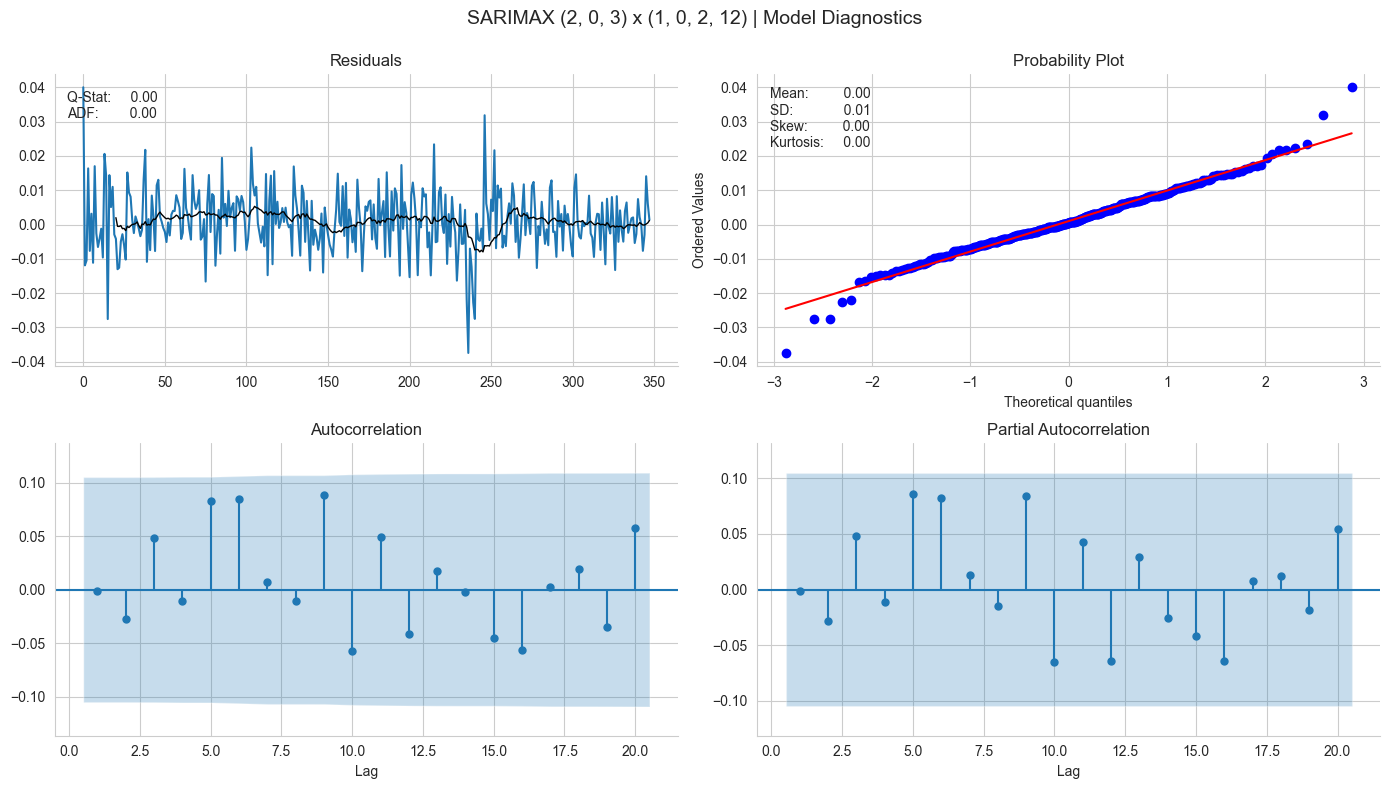

In [128]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')